# Collaboration and Competition - Udacity DRLND Project III

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

Please follow the instructions to obtain the prebuild simulator for your environment as marked in the "Getting started" section of README.md file in the repository.

Please select one of the two options below for loading the environment. __The option used here require the Udacity Workspace__ for the project. Please follow the instruction provided in the README.md file to setup your own environment.

Align path with environement specific settings.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.04500000085681677
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: 0.04500000085681677
Total score (averaged over agents) this episode: 0.04500000085681677
Total score (averaged over agents) this episode: -0.004999999888241291


__Optional:__ When finished, you can close the environment.

_Skip this step, in order to run the training_

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [5]:
import torch
from ddpg_agent import Agent
from ddpg_agent import ReplayBuffer
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

### 4.2 Create agent instances for training

In [6]:
# define random seed and intialize shared replay buffer
random_seed = int(np.random.rand()*100)
BUFFER_SIZE = int(1e6)
BATCH_SIZE = 256

# shared replay buffer for multi-agent setup
shared_rep_buffer = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)

# create agents - ddpg_agent.py implements multi-agent support
agent = Agent(num_agents=num_agents,
              state_size=state_size,
              action_size=action_size,
              random_seed=0,
              shared_rep_buffer=shared_rep_buffer)

### 4.3 Defining the training function

In [7]:
def ddpg_train(agent, n_episodes=10000, max_t=1000):

    scores_agents = []
    scores_interval = deque(maxlen=100)
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]              # reset the environment  
        states = env_info.vector_observations                          # get the current state (for each agent)
        agent.reset()                                                  # reset the agent
        scores = np.zeros(num_agents)
        
        for t in range(max_t):            
            actions = agent.act(states)                               # define agents actions
            env_info = env.step(actions)[brain_name]                   # send all actions to tne environment
            next_states = env_info.vector_observations                 # get next state (for each agent)
            rewards = env_info.rewards                                 # get reward (for each agent)
            dones = env_info.local_done                                # see if episode finished
            agent.step(states, actions, rewards, next_states, dones)
            
            scores += rewards                                          # update the score (for each agent)
            states = next_states                                       # roll over states to next time step
            print(f'\rEpisode {i_episode}\tTimestep {t}'
                  f'\tScore: {np.mean(scores):.2f}', end="")
            if np.any(dones):
                break
        
        # calculate the mean score over the last hundred episodes
        score = np.mean(scores)
        scores_agents.append(score)
        scores_interval.append(score)
        mean_score = np.mean(scores_interval)

        # print the result for each episode and         
        print(f'\rEpisode {i_episode}'
              f'\tMean score (last 100 episodes): {mean_score:.2f}')
        
        # environment is solved, when the mean score of all agents over the last 100 episodes exceeds 0.5 
        if mean_score >= 0.5:
            print(f'\nEnvironment solved in {i_episode:d} episodes!'
                  f'\tMean score (last 100 episodes): {mean_score:.2f}')
            
            # store the model weights for actor_local and critic_local to file
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break
            
    return scores_agents

### 4.4 Train the agent

In [8]:
scores = ddpg_train(agent)

Episode 1	Mean score (last 100 episodes): 0.05
Episode 2	Mean score (last 100 episodes): 0.05
Episode 3	Mean score (last 100 episodes): 0.03
Episode 4	Mean score (last 100 episodes): 0.02
Episode 5	Mean score (last 100 episodes): 0.02
Episode 6	Mean score (last 100 episodes): 0.01
Episode 7	Mean score (last 100 episodes): 0.01
Episode 8	Mean score (last 100 episodes): 0.01
Episode 9	Mean score (last 100 episodes): 0.01
Episode 10	Mean score (last 100 episodes): 0.01
Episode 11	Mean score (last 100 episodes): 0.00
Episode 12	Mean score (last 100 episodes): 0.00
Episode 13	Mean score (last 100 episodes): 0.00
Episode 14	Mean score (last 100 episodes): 0.00
Episode 15	Mean score (last 100 episodes): 0.00
Episode 16	Mean score (last 100 episodes): 0.00
Episode 17	Mean score (last 100 episodes): 0.00
Episode 18	Mean score (last 100 episodes): 0.00
Episode 19	Mean score (last 100 episodes): 0.00
Episode 20	Mean score (last 100 episodes): 0.00
Episode 21	Mean score (last 100 episodes): 0.00
E

Episode 168	Mean score (last 100 episodes): -0.00
Episode 169	Mean score (last 100 episodes): -0.00
Episode 170	Mean score (last 100 episodes): -0.00
Episode 171	Mean score (last 100 episodes): -0.00
Episode 172	Mean score (last 100 episodes): -0.00
Episode 173	Mean score (last 100 episodes): -0.00
Episode 174	Mean score (last 100 episodes): -0.00
Episode 175	Mean score (last 100 episodes): -0.00
Episode 176	Mean score (last 100 episodes): -0.00
Episode 177	Mean score (last 100 episodes): -0.00
Episode 178	Mean score (last 100 episodes): -0.00
Episode 179	Mean score (last 100 episodes): -0.00
Episode 180	Mean score (last 100 episodes): -0.00
Episode 181	Mean score (last 100 episodes): -0.00
Episode 182	Mean score (last 100 episodes): -0.00
Episode 183	Mean score (last 100 episodes): -0.00
Episode 184	Mean score (last 100 episodes): -0.00
Episode 185	Mean score (last 100 episodes): -0.00
Episode 186	Mean score (last 100 episodes): -0.00
Episode 187	Mean score (last 100 episodes): -0.00


Episode 332	Mean score (last 100 episodes): -0.00
Episode 333	Mean score (last 100 episodes): -0.00
Episode 334	Mean score (last 100 episodes): -0.00
Episode 335	Mean score (last 100 episodes): -0.00
Episode 336	Mean score (last 100 episodes): -0.00
Episode 337	Mean score (last 100 episodes): -0.00
Episode 338	Mean score (last 100 episodes): -0.00
Episode 339	Mean score (last 100 episodes): -0.00
Episode 340	Mean score (last 100 episodes): -0.00
Episode 341	Mean score (last 100 episodes): -0.00
Episode 342	Mean score (last 100 episodes): -0.00
Episode 343	Mean score (last 100 episodes): -0.00
Episode 344	Mean score (last 100 episodes): -0.00
Episode 345	Mean score (last 100 episodes): -0.00
Episode 346	Mean score (last 100 episodes): -0.00
Episode 347	Mean score (last 100 episodes): -0.00
Episode 348	Mean score (last 100 episodes): -0.00
Episode 349	Mean score (last 100 episodes): -0.00
Episode 350	Mean score (last 100 episodes): -0.00
Episode 351	Mean score (last 100 episodes): -0.00


Episode 496	Mean score (last 100 episodes): -0.00
Episode 497	Mean score (last 100 episodes): -0.00
Episode 498	Mean score (last 100 episodes): -0.00
Episode 499	Mean score (last 100 episodes): -0.00
Episode 500	Mean score (last 100 episodes): -0.00
Episode 501	Mean score (last 100 episodes): -0.00
Episode 502	Mean score (last 100 episodes): -0.00
Episode 503	Mean score (last 100 episodes): -0.00
Episode 504	Mean score (last 100 episodes): -0.00
Episode 505	Mean score (last 100 episodes): -0.00
Episode 506	Mean score (last 100 episodes): -0.00
Episode 507	Mean score (last 100 episodes): -0.00
Episode 508	Mean score (last 100 episodes): -0.00
Episode 509	Mean score (last 100 episodes): -0.00
Episode 510	Mean score (last 100 episodes): -0.00
Episode 511	Mean score (last 100 episodes): -0.00
Episode 512	Mean score (last 100 episodes): -0.00
Episode 513	Mean score (last 100 episodes): -0.00
Episode 514	Mean score (last 100 episodes): -0.00
Episode 515	Mean score (last 100 episodes): -0.00


Episode 660	Mean score (last 100 episodes): -0.00
Episode 661	Mean score (last 100 episodes): -0.00
Episode 662	Mean score (last 100 episodes): -0.00
Episode 663	Mean score (last 100 episodes): -0.00
Episode 664	Mean score (last 100 episodes): -0.00
Episode 665	Mean score (last 100 episodes): -0.00
Episode 666	Mean score (last 100 episodes): -0.00
Episode 667	Mean score (last 100 episodes): -0.00
Episode 668	Mean score (last 100 episodes): -0.00
Episode 669	Mean score (last 100 episodes): -0.00
Episode 670	Mean score (last 100 episodes): -0.00
Episode 671	Mean score (last 100 episodes): -0.00
Episode 672	Mean score (last 100 episodes): -0.00
Episode 673	Mean score (last 100 episodes): -0.00
Episode 674	Mean score (last 100 episodes): -0.00
Episode 675	Mean score (last 100 episodes): -0.00
Episode 676	Mean score (last 100 episodes): -0.00
Episode 677	Mean score (last 100 episodes): -0.00
Episode 678	Mean score (last 100 episodes): -0.00
Episode 679	Mean score (last 100 episodes): -0.00


Episode 824	Mean score (last 100 episodes): -0.00
Episode 825	Mean score (last 100 episodes): -0.00
Episode 826	Mean score (last 100 episodes): -0.00
Episode 827	Mean score (last 100 episodes): -0.00
Episode 828	Mean score (last 100 episodes): -0.00
Episode 829	Mean score (last 100 episodes): -0.00
Episode 830	Mean score (last 100 episodes): -0.00
Episode 831	Mean score (last 100 episodes): -0.00
Episode 832	Mean score (last 100 episodes): -0.00
Episode 833	Mean score (last 100 episodes): -0.00
Episode 834	Mean score (last 100 episodes): -0.00
Episode 835	Mean score (last 100 episodes): -0.00
Episode 836	Mean score (last 100 episodes): -0.00
Episode 837	Mean score (last 100 episodes): -0.00
Episode 838	Mean score (last 100 episodes): -0.00
Episode 839	Mean score (last 100 episodes): -0.00
Episode 840	Mean score (last 100 episodes): -0.00
Episode 841	Mean score (last 100 episodes): -0.00
Episode 842	Mean score (last 100 episodes): -0.00
Episode 843	Mean score (last 100 episodes): -0.00


Episode 988	Mean score (last 100 episodes): -0.00
Episode 989	Mean score (last 100 episodes): -0.00
Episode 990	Mean score (last 100 episodes): -0.00
Episode 991	Mean score (last 100 episodes): -0.00
Episode 992	Mean score (last 100 episodes): -0.00
Episode 993	Mean score (last 100 episodes): -0.00
Episode 994	Mean score (last 100 episodes): -0.00
Episode 995	Mean score (last 100 episodes): -0.00
Episode 996	Mean score (last 100 episodes): -0.00
Episode 997	Mean score (last 100 episodes): -0.00
Episode 998	Mean score (last 100 episodes): -0.00
Episode 999	Mean score (last 100 episodes): -0.00
Episode 1000	Mean score (last 100 episodes): -0.00
Episode 1001	Mean score (last 100 episodes): -0.00
Episode 1002	Mean score (last 100 episodes): -0.00
Episode 1003	Mean score (last 100 episodes): -0.00
Episode 1004	Mean score (last 100 episodes): -0.00
Episode 1005	Mean score (last 100 episodes): -0.00
Episode 1006	Mean score (last 100 episodes): -0.00
Episode 1007	Mean score (last 100 episodes)

Episode 1149	Mean score (last 100 episodes): -0.00
Episode 1150	Mean score (last 100 episodes): -0.00
Episode 1151	Mean score (last 100 episodes): -0.00
Episode 1152	Mean score (last 100 episodes): -0.00
Episode 1153	Mean score (last 100 episodes): -0.00
Episode 1154	Mean score (last 100 episodes): -0.00
Episode 1155	Mean score (last 100 episodes): -0.00
Episode 1156	Mean score (last 100 episodes): -0.00
Episode 1157	Mean score (last 100 episodes): -0.00
Episode 1158	Mean score (last 100 episodes): -0.00
Episode 1159	Mean score (last 100 episodes): -0.00
Episode 1160	Mean score (last 100 episodes): -0.00
Episode 1161	Mean score (last 100 episodes): -0.00
Episode 1162	Mean score (last 100 episodes): -0.00
Episode 1163	Mean score (last 100 episodes): -0.00
Episode 1164	Mean score (last 100 episodes): -0.00
Episode 1165	Mean score (last 100 episodes): -0.00
Episode 1166	Mean score (last 100 episodes): -0.00
Episode 1167	Mean score (last 100 episodes): -0.00
Episode 1168	Mean score (last 1

Episode 1475	Mean score (last 100 episodes): 0.09
Episode 1476	Mean score (last 100 episodes): 0.09
Episode 1477	Mean score (last 100 episodes): 0.09
Episode 1478	Mean score (last 100 episodes): 0.09
Episode 1479	Mean score (last 100 episodes): 0.09
Episode 1480	Mean score (last 100 episodes): 0.09
Episode 1481	Mean score (last 100 episodes): 0.09
Episode 1482	Mean score (last 100 episodes): 0.09
Episode 1483	Mean score (last 100 episodes): 0.09
Episode 1484	Mean score (last 100 episodes): 0.09
Episode 1485	Mean score (last 100 episodes): 0.09
Episode 1486	Mean score (last 100 episodes): 0.10
Episode 1487	Mean score (last 100 episodes): 0.10
Episode 1488	Mean score (last 100 episodes): 0.10
Episode 1489	Mean score (last 100 episodes): 0.10
Episode 1490	Mean score (last 100 episodes): 0.10
Episode 1491	Mean score (last 100 episodes): 0.10
Episode 1492	Mean score (last 100 episodes): 0.10
Episode 1493	Mean score (last 100 episodes): 0.10
Episode 1494	Mean score (last 100 episodes): 0.10


Episode 1639	Mean score (last 100 episodes): 0.11
Episode 1640	Mean score (last 100 episodes): 0.11
Episode 1641	Mean score (last 100 episodes): 0.11
Episode 1642	Mean score (last 100 episodes): 0.11
Episode 1643	Mean score (last 100 episodes): 0.11
Episode 1644	Mean score (last 100 episodes): 0.11
Episode 1645	Mean score (last 100 episodes): 0.11
Episode 1646	Mean score (last 100 episodes): 0.11
Episode 1647	Mean score (last 100 episodes): 0.11
Episode 1648	Mean score (last 100 episodes): 0.11
Episode 1649	Mean score (last 100 episodes): 0.11
Episode 1650	Mean score (last 100 episodes): 0.11
Episode 1651	Mean score (last 100 episodes): 0.11
Episode 1652	Mean score (last 100 episodes): 0.11
Episode 1653	Mean score (last 100 episodes): 0.11
Episode 1654	Mean score (last 100 episodes): 0.11
Episode 1655	Mean score (last 100 episodes): 0.11
Episode 1656	Mean score (last 100 episodes): 0.11
Episode 1657	Mean score (last 100 episodes): 0.11
Episode 1658	Mean score (last 100 episodes): 0.11


Episode 1803	Mean score (last 100 episodes): 0.13
Episode 1804	Mean score (last 100 episodes): 0.13
Episode 1805	Mean score (last 100 episodes): 0.13
Episode 1806	Mean score (last 100 episodes): 0.13
Episode 1807	Mean score (last 100 episodes): 0.12
Episode 1808	Mean score (last 100 episodes): 0.12
Episode 1809	Mean score (last 100 episodes): 0.12
Episode 1810	Mean score (last 100 episodes): 0.12
Episode 1811	Mean score (last 100 episodes): 0.12
Episode 1812	Mean score (last 100 episodes): 0.12
Episode 1813	Mean score (last 100 episodes): 0.12
Episode 1814	Mean score (last 100 episodes): 0.12
Episode 1815	Mean score (last 100 episodes): 0.12
Episode 1816	Mean score (last 100 episodes): 0.12
Episode 1817	Mean score (last 100 episodes): 0.12
Episode 1818	Mean score (last 100 episodes): 0.12
Episode 1819	Mean score (last 100 episodes): 0.12
Episode 1820	Mean score (last 100 episodes): 0.12
Episode 1821	Mean score (last 100 episodes): 0.12
Episode 1822	Mean score (last 100 episodes): 0.12


Episode 1967	Mean score (last 100 episodes): 0.14
Episode 1968	Mean score (last 100 episodes): 0.14
Episode 1969	Mean score (last 100 episodes): 0.14
Episode 1970	Mean score (last 100 episodes): 0.14
Episode 1971	Mean score (last 100 episodes): 0.14
Episode 1972	Mean score (last 100 episodes): 0.14
Episode 1973	Mean score (last 100 episodes): 0.14
Episode 1974	Mean score (last 100 episodes): 0.14
Episode 1975	Mean score (last 100 episodes): 0.14
Episode 1976	Mean score (last 100 episodes): 0.14
Episode 1977	Mean score (last 100 episodes): 0.14
Episode 1978	Mean score (last 100 episodes): 0.14
Episode 1979	Mean score (last 100 episodes): 0.14
Episode 1980	Mean score (last 100 episodes): 0.14
Episode 1981	Mean score (last 100 episodes): 0.14
Episode 1982	Mean score (last 100 episodes): 0.14
Episode 1983	Mean score (last 100 episodes): 0.14
Episode 1984	Mean score (last 100 episodes): 0.14
Episode 1985	Mean score (last 100 episodes): 0.14
Episode 1986	Mean score (last 100 episodes): 0.14


Episode 2131	Mean score (last 100 episodes): 0.38
Episode 2132	Mean score (last 100 episodes): 0.38
Episode 2133	Mean score (last 100 episodes): 0.38
Episode 2134	Mean score (last 100 episodes): 0.38
Episode 2135	Mean score (last 100 episodes): 0.37
Episode 2136	Mean score (last 100 episodes): 0.37
Episode 2137	Mean score (last 100 episodes): 0.39
Episode 2138	Mean score (last 100 episodes): 0.39
Episode 2139	Mean score (last 100 episodes): 0.39
Episode 2140	Mean score (last 100 episodes): 0.38
Episode 2141	Mean score (last 100 episodes): 0.38
Episode 2142	Mean score (last 100 episodes): 0.38
Episode 2143	Mean score (last 100 episodes): 0.38
Episode 2144	Mean score (last 100 episodes): 0.38
Episode 2145	Mean score (last 100 episodes): 0.39
Episode 2146	Mean score (last 100 episodes): 0.39
Episode 2147	Mean score (last 100 episodes): 0.40
Episode 2148	Mean score (last 100 episodes): 0.40
Episode 2149	Mean score (last 100 episodes): 0.40
Episode 2150	Mean score (last 100 episodes): 0.40


### 4.5 Plot the results

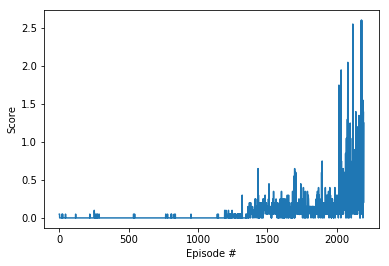

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [10]:
# agents use actor and critic network - describe networks
print(agent.actor_target)
print(agent.critic_target)

Actor(
  (fc1): Linear(in_features=24, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
)
Critic(
  (fcs1): Linear(in_features=24, out_features=256, bias=True)
  (fc2): Linear(in_features=258, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=1, bias=True)
)


### 4.6 Close the environment

In [11]:
env.close()